In [1]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"kumarkanha","key":"853f8ec67b1b3df16510eb5f102243c0"}

with open('/content/.kaggle/kaggle.json', 'w') as f:
  	json.dump(token,f)

!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download -d janmejaybhoi/cotton-disease-dataset  -p/content
!unzip  \*.zip

- path is now set to: {/content}
 95% 140M/148M [00:01<00:00, 72.3MB/s]
100% 148M/148M [00:02<00:00, 76.5MB/s]
Archive:  cotton-disease-dataset.zip
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (124).jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (153)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (173)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (175)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (183)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (193)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (194)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (204)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (206)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis_leaf (214)_iaip.jpg  
  inflating: Cotton Disease/test/diseased cotton leaf/dis

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

print(keras.__version__)

2.4.3


In [3]:
train_data_path = "/content/Cotton Disease/train"
validation_data_path = "/content/Cotton Disease/val"

In [4]:
def plotImage(image_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(image_arr, axes):
    ax.imshow(img)

  plt.tight_layout()
  plt.show()

In [5]:
trainig_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = 'nearest'
)

traing_data = trainig_datagen.flow_from_directory(train_data_path,
                                                  target_size = (150,150),
                                                  batch_size = 32,
                                                  class_mode= 'binary')

Found 1951 images belonging to 4 classes.


In [6]:
traing_data.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [7]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_data = valid_datagen.flow_from_directory(validation_data_path,
                                                  target_size = (150,150),
                                                  batch_size = 32,
                                                  class_mode= 'binary')

Found 253 images belonging to 4 classes.


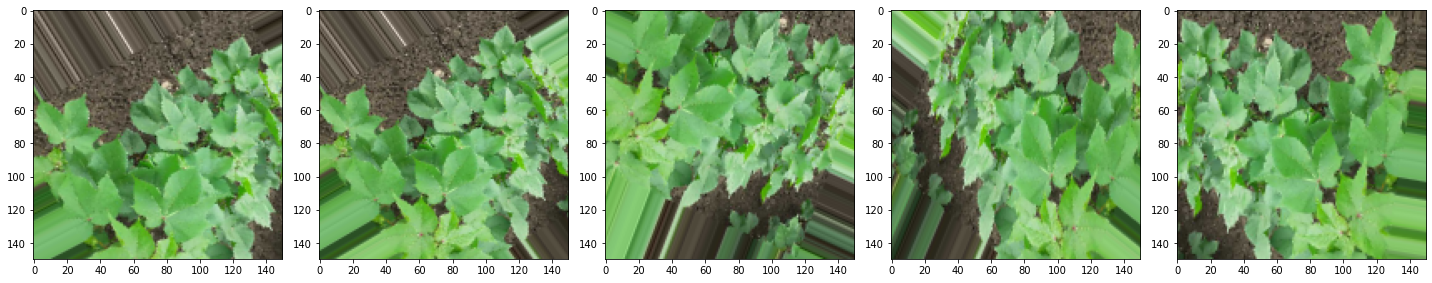

In [8]:
images=[traing_data[0][0][0] for i in range(5)]
plotImage(images)

In [9]:
model_path = "/content/drive/MyDrive/Colab Notebooks/model"
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, model = 'max')
callback_list = [checkpoint]

In [10]:
cnn_model = keras.models.Sequential([
                                     keras.layers.Conv2D(filters=32, kernel_size=3, input_shape=[150,150,3]),
                                     keras.layers.MaxPooling2D(pool_size=(2,2)),
                                     keras.layers.Conv2D(filters=64, kernel_size=3),
                                     keras.layers.MaxPooling2D(pool_size=(2,2)),
                                     keras.layers.Conv2D(filters=128, kernel_size=3),
                                     keras.layers.MaxPooling2D(pool_size=(2,2)),
                                     keras.layers.Conv2D(filters=256, kernel_size=3),
                                     keras.layers.MaxPooling2D(pool_size=(2,2)),

                                     keras.layers.Dropout(0.5),
                                     keras.layers.Flatten(),
                                     keras.layers.Dense(units=128, activation='relu'),
                                     keras.layers.Dropout(0.2),
                                     keras.layers.Dense(units=256, activation='relu'),
                                     keras.layers.Dropout(0.25),
                                     keras.layers.Dense(units=4, activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

In [12]:
history = cnn_model.fit(traing_data,
                        epochs=500,
                        validation_data=valid_data,
                        callbacks=callback_list
                        )

Epoch 1/500
61/61 [==============================] - ETA: 0s - loss: 1.2560 - accuracy: 0.4464
Epoch 00001: val_accuracy improved from -inf to 0.50593, saving model to /content/drive/MyDrive/Colab Notebooks/model
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/model/assets
61/61 [==============================] - 24s 393ms/step - loss: 1.2560 - accuracy: 0.4464 - val_loss: 1.0783 - val_accuracy: 0.5059
Epoch 2/500
61/61 [==============================] - ETA: 0s - loss: 1.0694 - accuracy: 0.5510
Epoch 00002: val_accuracy did not improve from 0.50593
61/61 [==============================] - 22s 353ms/step - loss: 1.0694 - accuracy: 0.5510 - val_loss: 1.0981 - val_accuracy: 0.4862
Epoch 3/500
61/61 [==============================] -

In [14]:
model_path = "/content/drive/MyDrive/Colab Notebooks/model/cotten_Dis/pred_cottn_dis_v2.h5"
cnn_model.save(model_path)

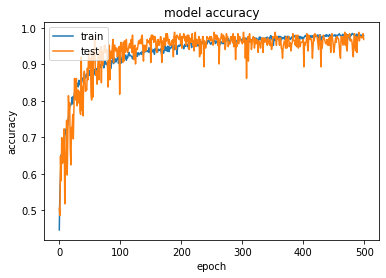

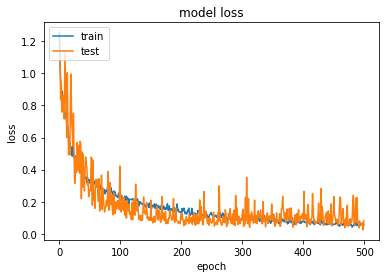

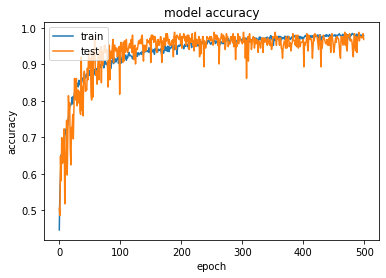

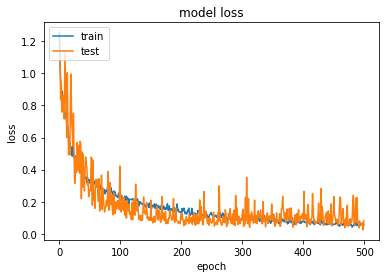

In [13]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="upper left")
plt.show()

#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="upper left")
plt.show()